In [27]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from airpollution_trf_graph_loader import AirpollutionDatasetLoader

pd.options.display.float_format = '{:,.3f}'.format

#Supress warnings
import warnings
warnings.filterwarnings('ignore')

### Auxiliary functions

In [28]:
def mape_fn(actual, pred):
    #print(actual)
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / (actual+0.01))) * 100

def compute_metrics_as_dataframe_fn(y_valid, y_hat, particle_name):
    metrics= []
    metrics_global = {'mse':[],'rmse':[],'mae':[],'cvrmse':[],'mape':[],}

    try:
        mae = mean_absolute_error(y_valid, y_hat)
        mse = mean_squared_error(y_valid, y_hat)
        rmse= mean_squared_error(y_valid, y_hat, squared = False)
        cvrmse =  (rmse/np.mean(y_valid))*100 # it is a percentage
        mape = mape_fn(y_valid, y_hat)

        metrics.append((time_horizon, str(particle_name), mae, mse, rmse, cvrmse, mape))


        metrics_df = pd.DataFrame.from_records(metrics, columns='T particle MAE MSE RMSE CVRMSE MAPE'.split())

        return metrics_df
    except:
        return None

def compute_metrics(y_valid, y_hat):
    metrics= []
    metrics_global = {'mse':[],'rmse':[],'mae':[],'cvrmse':[],'mape':[],}

    mae = mean_absolute_error(y_valid, y_hat)
    mse = mean_squared_error(y_valid, y_hat)
    rmse= mean_squared_error(y_valid, y_hat, squared = False)
    cvrmse =  (rmse/np.mean(y_valid))*100 # it is a percentage
    mape = mape_fn(y_valid, y_hat)

    return mae, mse, rmse, cvrmse, mape

In [29]:
T_lst= [6,12,24,48] #target time horizons to analyze
city_lst= 'madrid bilbao'.split()
_synth= True #use or not the results with synth data
n_layers= 2 #number of lstm layers in the used GNN

results_path='results'
if n_layers==2:
    results_path= 'results_2lstmlayers'



************************
madrid_synth
********
METRICS BY POLLUTANT
****
madrid_synth - 6h time horizon
                       MAE       MSE   RMSE  CVRMSE      MAPE
pollutant T traffic                                          
CO        6 no_trf   0.225     0.121  0.326  90.589    69.859
            trf      0.229     0.121  0.328  90.926    70.889
O3        6 no_trf  30.816 1,484.918 38.038  72.013 7,466.986
            trf     30.887 1,494.823 38.150  72.233 6,790.687
PM10      6 no_trf  12.112   336.610 16.896  70.981    70.320
            trf     12.147   331.868 16.948  71.429    72.564
PM25      6 no_trf   5.159    53.172  7.097  69.089    87.676
            trf      5.150    53.091  7.120  69.383    90.264
SO2       6 no_trf   0.601     0.987  0.958  77.091    45.848
            trf      0.591     0.993  0.964  77.566    44.587
****
madrid_synth - 12h time horizon
                        MAE       MSE   RMSE  CVRMSE       MAPE
pollutant T  traffic                             

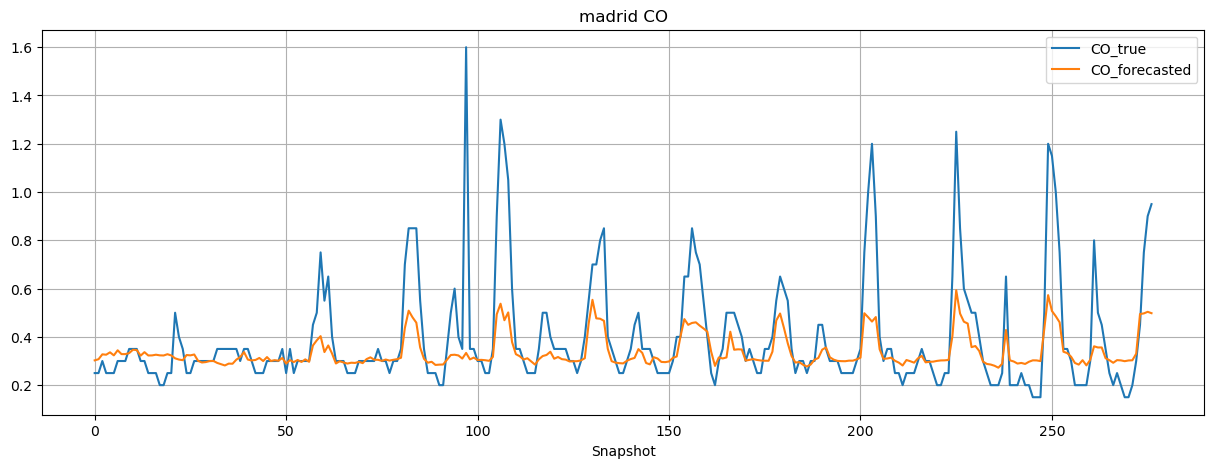

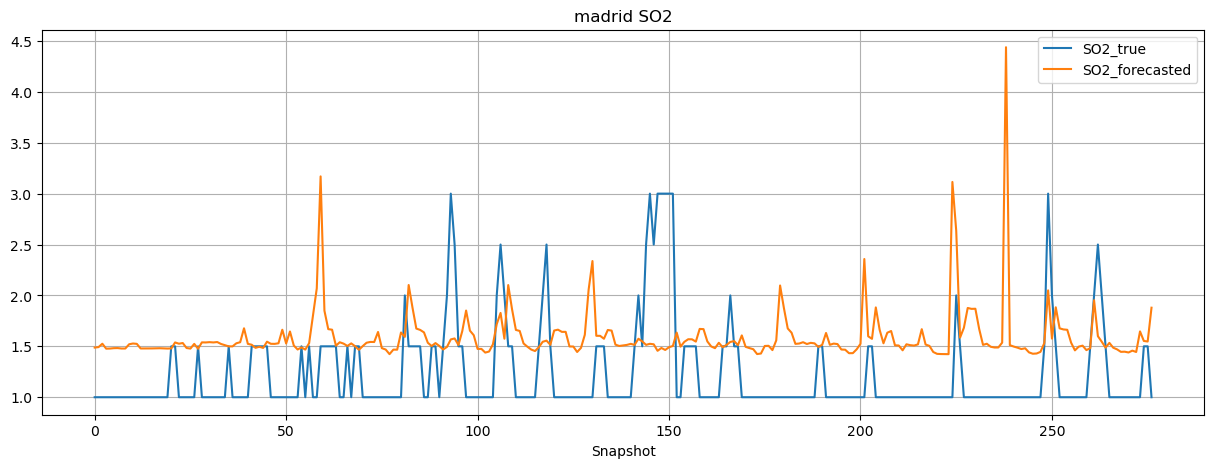

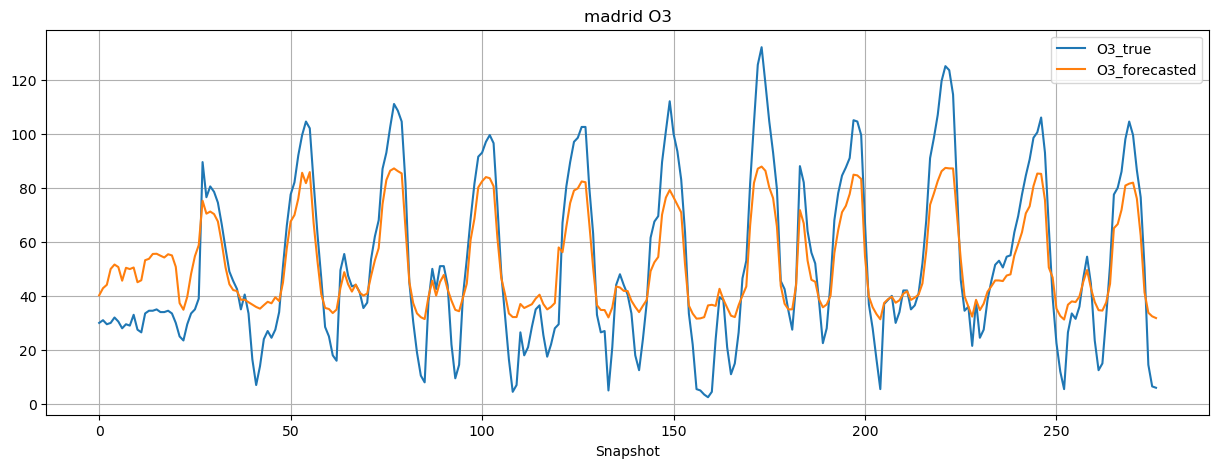

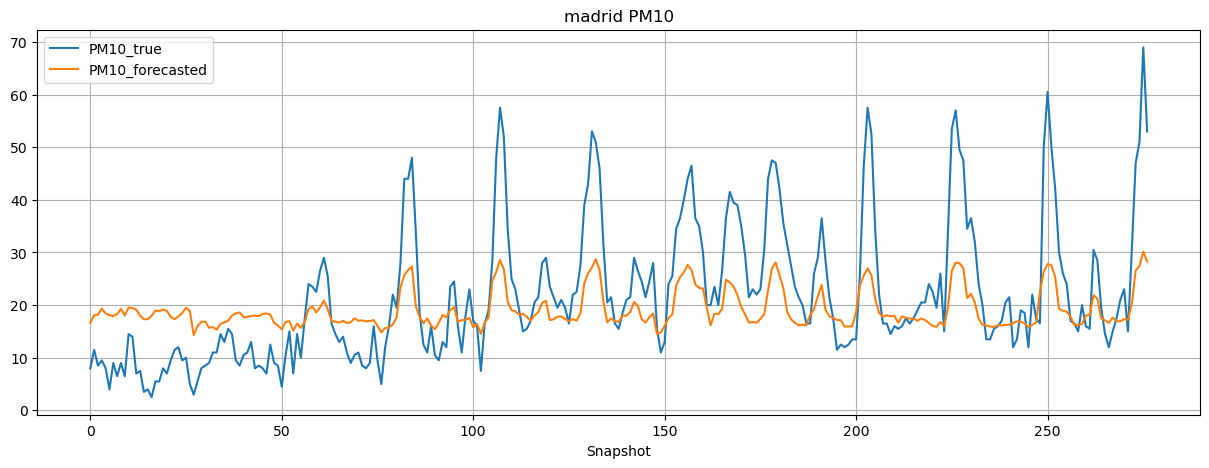

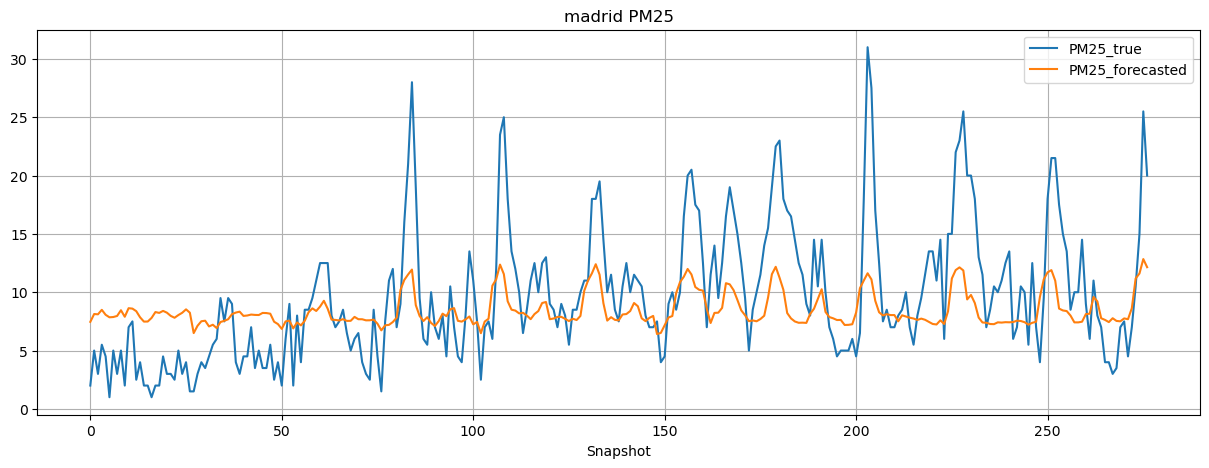

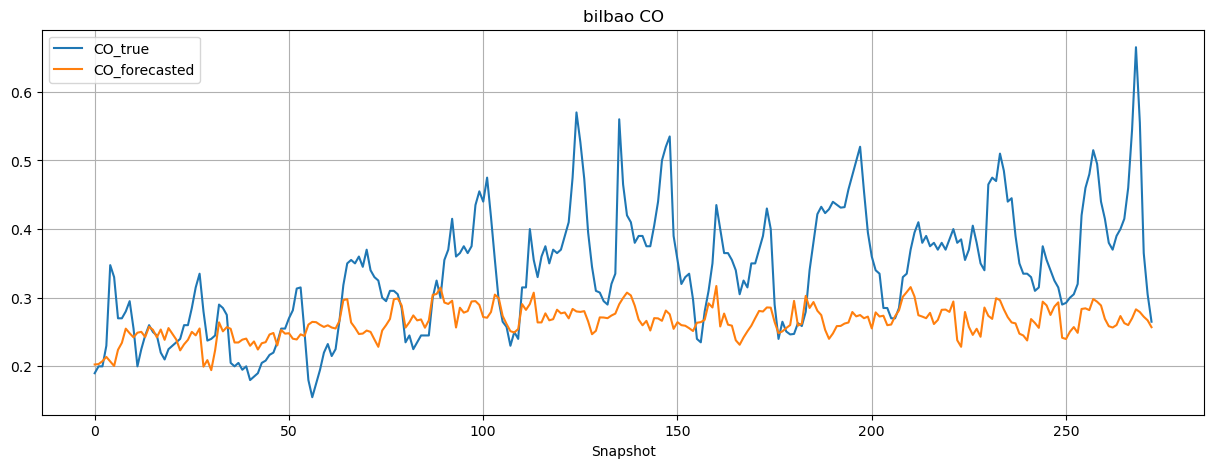

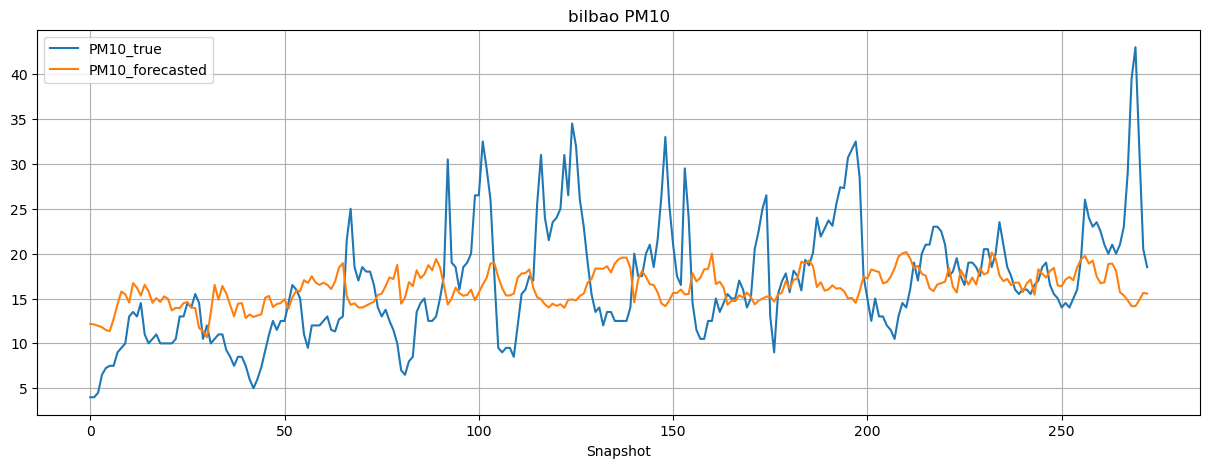

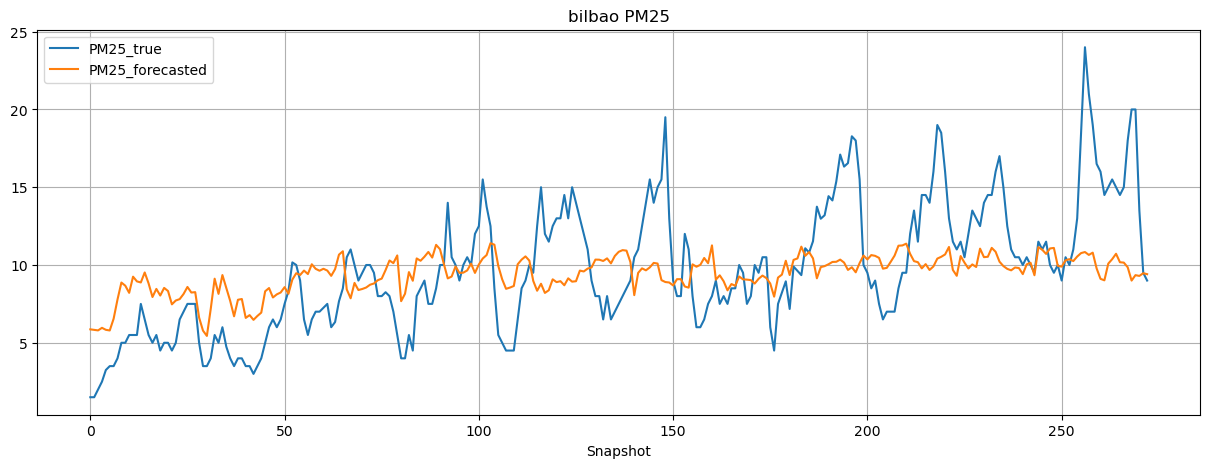

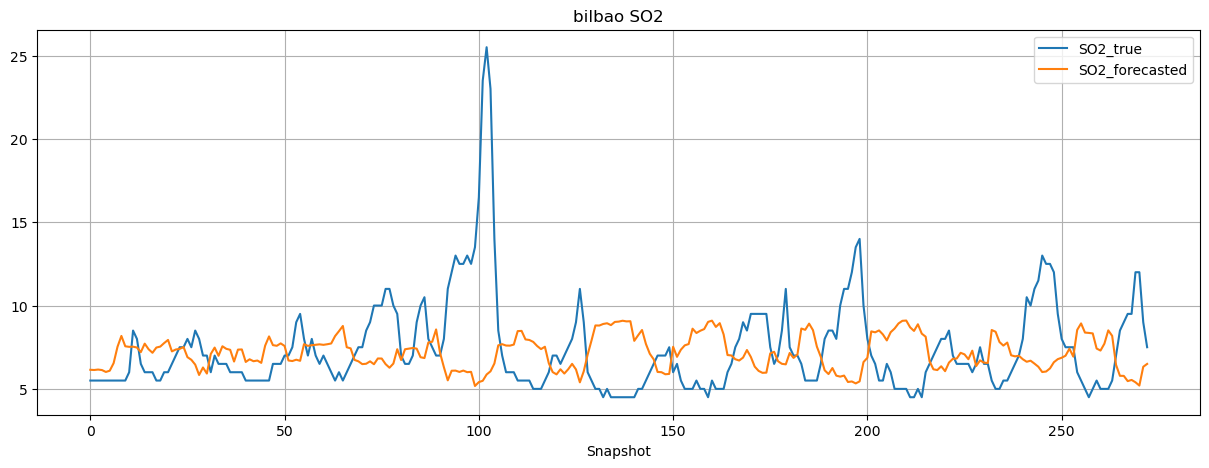

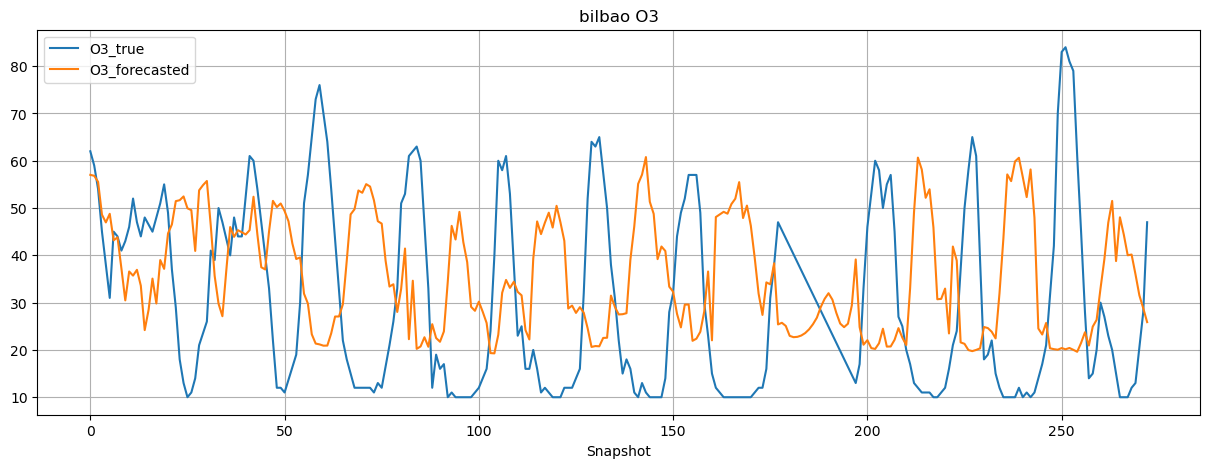

In [30]:
synth_data_str=""
if _synth:
    synth_data_str="_synth"

n_layers_str=""
if n_layers > 1 :
    n_layers_str= f'_{n_layers}'

for _city in city_lst:
    print("\n")
    print("*"*24)

    print(f"{_city}{synth_data_str}")
    loader= AirpollutionDatasetLoader(_city)
    dataset=loader.get_dataset(T=T_lst[0])

    feature_dim= loader.get_feature_dim()
    target_nodes= list(feature_dim.keys())

    y_hat_dict= {}
    y_true_dict= {}
    
    for _trf_str in ['trf', 'no_trf']:    
        for _T in T_lst:
            for k in target_nodes:
                if (_trf_str !=  'no_trf') or (k != 'trf'):
                    _df= pd.read_csv(os.path.join(results_path,f'y_hat_{_city}_{_T}_{k}_{_trf_str}{synth_data_str}.csv'), index_col=0)
                    y_hat_dict['_'.join([str(_T),k,_trf_str])]= _df
                
                    _df= pd.read_csv(os.path.join(results_path,f'y_true_{_city}_{_T}_{k}_{_trf_str}{synth_data_str}.csv'), index_col=0)
                    y_true_dict['_'.join([str(_T),k,_trf_str])]= _df


    metrics_by_sensors= []
    metrics_by_pollutants= []
    for _trf_str in ['trf', 'no_trf']:    
        for _T in T_lst:
            for k in target_nodes:
                if k != 'trf':
                    y_true_df= y_true_dict['_'.join([str(_T),k,_trf_str])]
                    y_hat_df= y_hat_dict['_'.join([str(_T),k,_trf_str])]
                
                    #Metris by station
                    for i in range(y_true_df.shape[0]):
                        mae, mse, rmse, cvrmse, mape= compute_metrics(y_true_df.iloc[i], y_hat_df.iloc[i])
                        metrics_by_sensors.append((_T, _trf_str, k, i, mae, mse, rmse, cvrmse, mape))
                
                    for c in y_true_df.columns:
                        c_hat= y_hat_df[c].T
                        c_true= y_true_df[c].T
                        mae, mse, rmse, cvrmse, mape= compute_metrics(c_true, c_hat)
                        metrics_by_pollutants.append((_T, _trf_str, k, c, mae, mse, rmse, cvrmse, mape))
    
    
    metrics_by_sensors_df = pd.DataFrame.from_records(metrics_by_sensors, columns='T traffic sensor t MAE MSE RMSE CVRMSE MAPE'.split())
    metrics_by_pollutants_df = pd.DataFrame.from_records(metrics_by_pollutants, columns='T traffic sensor pollutant MAE MSE RMSE CVRMSE MAPE'.split())
    
    metrics_by_sensors_df.to_csv(os.path.join(results_path,f'metrics_by_sensor_{_city}{synth_data_str}.csv'))
    metrics_by_pollutants_df.to_csv(os.path.join(results_path,f'metrics_by_pollutant_{_city}{synth_data_str}.csv'))

    print("*"*8)
    print("METRICS BY POLLUTANT")
    for t in T_lst:
        print("*"*4)
        print(f"{_city}{synth_data_str} - {t}h time horizon")
        metric_agg_mean_df= metrics_by_pollutants_df[metrics_by_pollutants_df['T']==t].drop(columns='sensor').groupby('pollutant T traffic'.split()).mean()
        print(metric_agg_mean_df)

    """
    print("*"*8)
    print("METRICS BY SENSORS")
    for t in T_lst:
        print(f"{_city} - {t}h time horizon")
        metric_agg_mean_df= metrics_by_sensors_df[metrics_by_sensors_df['T']==t].groupby('sensor T traffic'.split()).mean()
        print(metric_agg_mean_df)  
        print("*"*4)  
    """
    print("*"*8)
    print("FORECASTED VS REAL PLOTS")

    T_to_plot= '24'
    if _city== 'bilbao':
        T_to_plot= '12'
    y_true_lst={}
    y_hat_lst={}
    for k,df in y_true_dict.items():
        T_k= k.split('_')[0]
        trf_k= k.split('_')[2]
        s_k = k.split('_')[1]
        if (T_to_plot == T_k) and (trf_k== 'trf') and (s_k != 'trf'): # We plot pollution sensors including traffic as input
            y_hat_df= y_hat_dict[k]
            for c in df.columns:
                df_lst= y_true_lst.get(c,[])
                df_lst.append(df[c].to_frame().reset_index())
                y_true_lst[c]= df_lst
    
                df_lst= y_hat_lst.get(c,[])
                df_lst.append(y_hat_df[c].to_frame().reset_index())
                y_hat_lst[c]= df_lst
    
    for k, lst in y_true_lst.items():
        
        df= pd.concat(lst, axis=0)
        df= df.groupby('index').mean()
        df= df.rename(columns={k:f'{k}_true'})
    
        lst2= y_hat_lst[k]
        y_hat_df= pd.concat(lst2, axis=0)
        y_hat_df= y_hat_df.groupby('index').mean()
        y_hat_df= y_hat_df.rename(columns={k:f'{k}_forecasted'})
        
        ax=df.plot(grid=True, figsize=(15,5));
        y_hat_df.plot(ax=ax, grid=True, xlabel='Snapshot', title=f'{_city} {k}');
        
        plt.savefig(os.path.join(os.path.join('figs', f'true_vs_forecast_{k}_{T_to_plot}_{_city}{synth_data_str}{n_layers_str}.png')), bbox_inches='tight')

## Comparison synth vs real data

In [31]:
_city='madrid'
T_lst= [6,12,24,48] #target time horizons to analyze

metrics_by_sensors_real_df= pd.read_csv(os.path.join(results_path,f'metrics_by_pollutant_{_city}.csv'), index_col=0)
metrics_by_sensors_real_no_trf_df= metrics_by_sensors_real_df[metrics_by_sensors_real_df['traffic']== 'no_trf']
metrics_by_sensors_real_trf_df= metrics_by_sensors_real_df[metrics_by_sensors_real_df['traffic']== 'trf']

metrics_by_sensors_synth_df= pd.read_csv(os.path.join(results_path,f'metrics_by_pollutant_{_city}_synth.csv'), index_col=0)
metrics_by_sensors_synth_no_trf_df= metrics_by_sensors_synth_df[metrics_by_sensors_synth_df['traffic']== 'no_trf']
metrics_by_sensors_synth_trf_df= metrics_by_sensors_synth_df[metrics_by_sensors_synth_df['traffic']== 'trf']

metrics_by_sensors_real_trf_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'results_2lstmlayers\\metrics_by_pollutant_madrid.csv'

In [ ]:
metrics_by_sensors_real_trf_df['T'].unique(), metrics_by_sensors_synth_trf_df['T'].unique()

In [ ]:
pollutants_lst= metrics_by_sensors_real_trf_df['pollutant'].unique()
pollutants_lst

In [ ]:
metric_real_trf_df= metrics_by_sensors_real_trf_df.drop(columns='sensor traffic T'.split()).groupby('pollutant'.split()).mean()
metric_real_trf_df

In [ ]:
metric_synth_trf_df= metrics_by_sensors_synth_trf_df.drop(columns='sensor traffic T'.split()).groupby('pollutant'.split()).mean()
metric_synth_trf_df

In [ ]:
v_dict_mean= {}
v_dict_std= {}

for T in T_lst:
        
        real_trf_df= metrics_by_sensors_real_trf_df[metrics_by_sensors_real_trf_df['T']==T]
        synth_trf_df= metrics_by_sensors_synth_trf_df[metrics_by_sensors_synth_trf_df['T']==T]

        real_no_trf_df= metrics_by_sensors_real_no_trf_df[metrics_by_sensors_real_no_trf_df['T']==T]
        synth_no_trf_df= metrics_by_sensors_synth_no_trf_df[metrics_by_sensors_synth_no_trf_df['T']==T]
    
        metric_synth_trf_df= synth_trf_df.drop(columns='sensor traffic T'.split()).groupby('pollutant'.split()).mean()
        metric_real_trf_df= real_trf_df.drop(columns='sensor traffic T'.split()).groupby('pollutant'.split()).mean()

        metric_synth_trf_std_df= synth_trf_df.drop(columns='sensor traffic T'.split()).groupby('pollutant'.split()).std()
        metric_real_trf_std_df= real_trf_df.drop(columns='sensor traffic T'.split()).groupby('pollutant'.split()).std()

        metric_synth_no_trf_df= synth_no_trf_df.drop(columns='sensor traffic T'.split()).groupby('pollutant'.split()).mean()
        metric_real_no_trf_df= real_no_trf_df.drop(columns='sensor traffic T'.split()).groupby('pollutant'.split()).mean()

        metric_synth_no_trf_std_df= synth_no_trf_df.drop(columns='sensor traffic T'.split()).groupby('pollutant'.split()).std()
        metric_real_no_trf_std_df= real_no_trf_df.drop(columns='sensor traffic T'.split()).groupby('pollutant'.split()).std()
    
        for p in pollutants_lst:
            for m in 'MAE RMSE MSE'.split():
                v_lst= v_dict_mean.get(f'{p}-{m}', [])

                real_mean_p=metric_real_trf_df.loc[p,m]
                synth_mean_p= metric_synth_trf_df.loc[p,m]
                
                real_mean_no_trf_p=metric_real_no_trf_df.loc[p,m]
                synth_mean_no_trf_p= metric_synth_no_trf_df.loc[p,m]

                v_lst.append((T,real_mean_no_trf_p, real_mean_p, synth_mean_no_trf_p, synth_mean_p))
                v_dict_mean[f'{p}-{m}']= v_lst

                v_lst= v_dict_std.get(f'{p}-{m}', [])

                real_std_p=metric_real_trf_std_df.loc[p,m]
                synth_std_p= metric_synth_trf_std_df.loc[p,m]

                real_std_no_trf_p=metric_real_no_trf_std_df.loc[p,m]
                synth_std_no_trf_p= metric_synth_no_trf_std_df.loc[p,m]
                
                v_lst.append((T, real_std_no_trf_p, real_std_p, synth_std_no_trf_p, synth_std_p))
                v_dict_std[f'{p}-{m}']= v_lst


for k, v in v_dict_mean.items():
    df= pd.DataFrame(v, columns='T Real-No_trf Real-trf Synth-No_trf Synth-trf'.split())
    std_df= pd.DataFrame(v_dict_std[k], columns='T Real-No_trf Real-trf Synth-No_trf Synth-trf'.split())
    #print(std_df)
    df= df.set_index('T')
    std_df= std_df.set_index('T')
    p,m= k.split('-')
    df.plot(kind='bar', figsize=(15,5), title=p, grid=True, fontsize=16, yerr= std_df, rot=0);
    plt.tight_layout()
    plt.xlabel('Time horizon (h)', fontsize=18)
    plt.ylabel(m, fontsize=18)
    plt.legend(fontsize = 16)
    plt.savefig(os.path.join('figs', f'real_vs_synth_{_city}_{p}_{m}.png'), bbox_inches='tight')

In [ ]:
print("That's all folks!")